In [33]:
#!pip install --upgrade pip
#!pip install --ignore-installed --upgrade tensorflow
#!pip install tensorflow-gpu

In [34]:
# makes plots / images embedded in the file
%matplotlib inline

In [35]:
# import data and keras layers
import numpy as np
from keras.datasets import mnist
from keras import backend as k
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, UpSampling2D, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from tqdm import tqdm
import matplotlib.pyplot as plt

In [36]:
(x1_train, y1_train), (x1_test, y1_test) = mnist.load_data()

# format data
x1_train = x1_train.astype('float32')
x1_train = np.reshape(x1_train, (len(x1_train), 28, 28, 1))
x1_test = np.reshape(x1_test, (len(x1_test), 28, 28, 1))

# scaling to get the image in [-1, 1] range
x1_train = (x1_train - 127.5) / 127.5

In [37]:
#Generator Model
generator = Sequential()
generator.add(Dense(128*7*7, input_dim = 100))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, (5, 5), padding = 'same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D())
generator.add(Conv2D(1, (5, 5), padding = 'same', activation = 'tanh'))
print(generator.summary())  
generator.compile(loss = 'binary_crossentropy', optimizer = 'adam')            

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 64)        0         
__________

In [38]:
#Discriminator Model
discriminator = Sequential()
discriminator.add(Conv2D(64, (5,5), strides = (2, 2), padding = 'same', input_shape=(28, 28, 1)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, (5,5), strides = (2, 2), padding = 'same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation = 'sigmoid'))
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam') 
print(discriminator.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
__________

In [39]:
#Combining the Generator and Discriminator
discriminator.trainable = False
ganInput = Input(shape = (100,))
generated = generator(ganInput)
ganOutput = discriminator(generated)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer = 'adam')
print(gan.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 28, 28, 1)         865025    
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 212865    
Total params: 1,077,890
Trainable params: 852,481
Non-trainable params: 225,409
_________________________________________________________________
None


In [40]:
#Training
def train(epochs = 1, batch_size = 128):
    batch_count = x1_train.shape[0] // batch_size
    for i in range(epochs):
            for j in tqdm(range(batch_count)):             
            
                # Get initial random input for generator
                input_noise = np.random.normal(0, 1, size=[batch_size, 100])
                # Real images
                image_batch = x1_train[np.random.randint(0, x1_train.shape[0], size=batch_size)]
                
                # Generating images
                generated_Images = generator.predict(input_noise, batch_size=batch_size)
            
                # concatinating the real and generated images
                X = np.concatenate([image_batch, generated_Images])

                # Labels for real and generated images
                y_Discriminator = np.zeros(2*batch_size)
            
                # One-sided label smoothing
                y_Discriminator[:batch_size] = 0.9

                # Train discriminator
                discriminator.trainable = True
                discriminator.train_on_batch(X, y_Discriminator)

                # Train generator
                noise = np.random.normal(0, 1, size=[batch_size, 100])
                y_Generator = np.ones(batch_size)
                discriminator.trainable = False
                gan.train_on_batch(input_noise, y_Generator)    

In [21]:
train(1, 128);

100%|██████████| 468/468 [23:34<00:00,  2.99s/it]


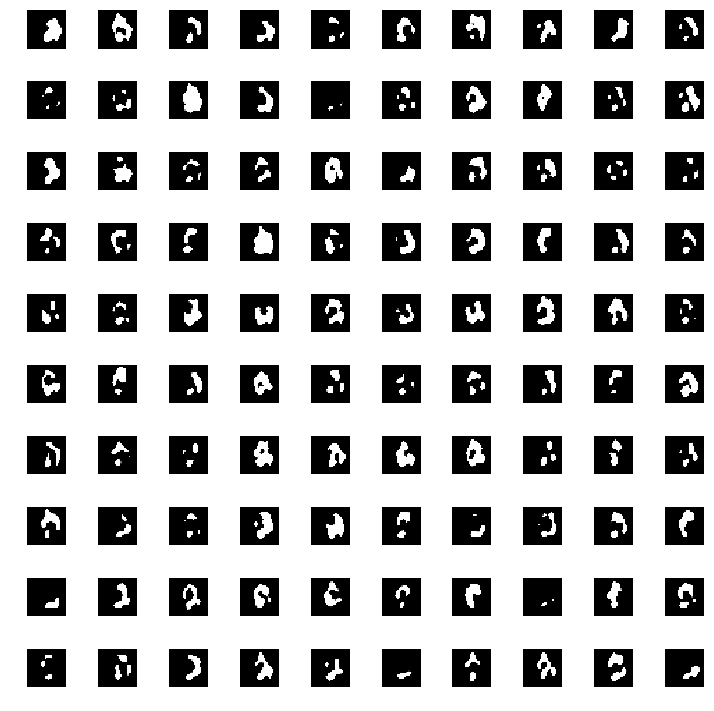

In [31]:
plotGeneratedImages()
generator.save('models/dcgan_generator.h5')
discriminator.save('models/dcgan_discriminator.h5')

In [32]:
def plotGeneratedImages():
    try_input = np.random.rand(100, 100)
    preds = generator.predict(try_input)

    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()